# Processing corrected samples

Datasets typically consist of several wells on a microscopy slide. In this notebook, the wells are integrated to one annotated data matrix.

In [1]:
import os
import platform
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
import multiprocessing
from joblib import Parallel, delayed
from importlib import reload
from tqdm import tqdm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import functools
import sys
sys.path.append('/home/mklein/spacem')
sys.path.append('/Volumes/mklein/spacem')
sys.path.append('/home/mklein/FDA_project')
from src.correction import get_matrices_from_dfs, normalize_proportion_ratios
from src import const
from src.evaluation import plot_all_ion_slopes

%matplotlib inline
%config InlineBackend.figure_formats = ['retina']

In [2]:
if platform.system() == "Darwin":
    target_path = '/Volumes/mklein/FDA_project/data/Lx_Glioblastoma'
else:
    target_path = '/home/mklein/FDA_project/data/Lx_Glioblastoma'
    
# this is the column of the annotated data matrix, that discriminates between conditions
condition_name = 'dataset_3'

In [3]:
# Parameters
source_path = "/home/mklein/Raw Data/220412_Luisa_ScSeahorse_SpaceM"
target_path = "/home/mklein/FDA_project/data/Mx_Seahorse"
condition_name = "treatment"
well_name = "rowcol"
analysis_path = "/home/mklein/FDA_project/analysis/Mx_Seahorse"
notebooks = [
    "pipeline_01_correction.ipynb",
    "pipeline_02_processing.ipynb",
    "pipeline_03_evaluation.ipynb",
]
project = "Mx_Seahorse"


In [4]:
samples = [dir.name for dir in os.scandir(target_path) if dir.is_dir() and dir.name[0] != "."]

files = {
        'am_sm_matrix': 'am_spatiomolecular_adata.h5ad',
        'corr_am_sm_matrix': 'am_spatiomolecular_adata_corrected.h5ad',
        'cell_sm_matrix': 'cells_spatiomolecular_adata_spacem.h5ad',
        'gen_cell_sm_matrix': 'cells_spatiomolecular_adata.h5ad',
        'corr_cell_sm_matrix': 'cells_spatiomolecular_adata_corrected.h5ad',
    }


After loading all individual wells, they are concatenated into one data matrix. Cell identifiers are kept unique by adding a well-specific suffix 

In [5]:
am_adata_dict = {}
am_adata_cor_dict = {}
adata_dict = {}
gen_adata_dict = {}
adata_cor_dict = {}

for sample in tqdm(samples):
    sample_path = os.path.join(target_path, sample)

    project_files = {k: os.path.join(sample_path, v) for k, v in files.items()}

    # am_adata_dict[sample] = sc.read(project_files['am_sm_matrix'])
    # am_adata_cor_dict[sample] = sc.read(project_files['corr_am_sm_matrix'])
    adata_dict[sample] = sc.read(project_files['cell_sm_matrix'])
    gen_adata_dict[sample] = sc.read(project_files['gen_cell_sm_matrix'])
    adata_cor_dict[sample] = sc.read(project_files['corr_cell_sm_matrix'])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.45it/s]


In [6]:
def split_dataset_info(adata):
    split = adata.obs['dataset'].str.split("_", expand=True)
    adata.obs[['dataset_' + str(col) for col in split.columns]] = split

The combination of wells is not restricted to concatenation of the corresponding data matrices. Some of the ion-related metadata, like the slopes used in ISM correction, are specific to the individual wells. Thus, they are summarised and mean values saved in the combined data matrices.

In [7]:
def plot_range_slopes(adata_dict):
    adata = ad.concat(adata_dict, label='well', index_unique="_", merge="first", join='inner', fill_value=0)
    conca_var_df = pd.concat({k: v.var for k, v in adata_dict.items()}).select_dtypes(include=[float])
    
    dfs = [conca_var_df.reset_index(names = ['well', 'ion']).groupby('ion').mean(numeric_only = True).reset_index().melt(id_vars=['ion'], value_name='mean'),
              conca_var_df.reset_index(names = ['well', 'ion']).groupby('ion').min(numeric_only = True).reset_index().melt(id_vars=['ion'], value_name='min'),
              conca_var_df.reset_index(names = ['well', 'ion']).groupby('ion').max(numeric_only = True).reset_index().melt(id_vars=['ion'], value_name='max')]

    sum_df = pd.merge(functools.reduce(lambda left,right: pd.merge(left, right, how='left', on=['ion', 'variable']), dfs), 
                      pd.concat({k: v.var for k, v in adata_cor_dict.items()})[['correction_using_ion_pool']].reset_index(names = ['well', 'ion']).groupby('ion').sum(numeric_only = True), 
                      left_on='ion', right_index=True)

    def my_bin(i):
        if i == len(adata_dict):
            return '4_all by pool'
        elif i == 0:
            return '0_none by pool'
        elif i >0.9*len(adata_dict):
            return '3_>90% by pool'
        elif i >0.5*len(adata_dict):
            return '2_>50% by pool'
        else:
            return '1_<50% by pool'
        
    sum_df['corr_pool_bins'] = [my_bin(i) for i in sum_df['correction_using_ion_pool']]
    #pd.cut(sum_df['correction_using_ion_pool'], bins=4)#, q=[0, .2, .4, .6, .8, 1], labels=['<20%', '<40%', '<60%', '<80%', '>80%'])
    
    sum_df = sum_df.sort_values(['correction_using_ion_pool'])
    
    fig, ax = plt.subplots(figsize=(16, 4))
    m = sns.lineplot(sum_df[sum_df.variable == 'correction_quantreg_slope'], x = 'ion', y='mean', hue='corr_pool_bins', ax=ax)
    sns.lineplot(sum_df[sum_df.variable == 'correction_quantreg_slope'], x = 'ion', y='min', hue='corr_pool_bins', ax=ax, linewidth=0.4)
    sns.lineplot(sum_df[sum_df.variable == 'correction_quantreg_slope'], x = 'ion', y='max', hue='corr_pool_bins', ax=ax, linewidth=0.4)
    ax.set_xticks([])
    ax.set_ylabel('mean, max and min slope')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:5], labels[:5], title='correction_using_ion_pool')
    ax.axhline(0)
    ax.axhline(-1)
    ax.set_title('Range of ISM correction slopes across wells')
    fig.tight_layout()

In [8]:
import functools
def concat_wells(adata_dict):
    adata = ad.concat(adata_dict, label='well', index_unique="_", merge="first", join='inner', fill_value=0)
    
    conca_var_df = pd.concat({k: v.var for k, v in adata_dict.items()}).select_dtypes(include=[float, bool])
    if 'correction_quantreg_slope' in conca_var_df.columns:

        mean_var_df = conca_var_df.reset_index(names = ['well', 'ion']).groupby('ion').mean(numeric_only = True)
        mean_var_df.columns = ['mean_'+col for col in mean_var_df.columns]
        
        std_var_df = conca_var_df.reset_index(names = ['well', 'ion']).groupby('ion').std(numeric_only = True)
        std_var_df.columns = ['sd_'+col for col in std_var_df.columns]
        
        count_var_df = conca_var_df.reset_index(names = ['well', 'ion']).groupby('ion').sum(numeric_only = True)
        count_var_df.columns = ['sum_'+col for col in count_var_df.columns]
        
        dfs = [adata.var, 
            mean_var_df[['mean_correction_full_pixel_avg_intensities', 'mean_correction_quantreg_slope', 'mean_correction_quantreg_intersect']], 
            std_var_df[['sd_correction_full_pixel_avg_intensities', 'sd_correction_quantreg_slope', 'sd_correction_quantreg_intersect']],
            count_var_df[['sum_correction_using_ion_pool']] ]
        
        adata.var = functools.reduce(lambda left,right: pd.merge(left, right, how='left', left_index=True, right_index=True), dfs)
        adata.var['corrected_only_using_pool'] = adata.var['sum_correction_using_ion_pool'] == len(adata_dict)
        
    #sc.tl.pca(adata)
    #sc.external.pp.bbknn(adata, batch_key='well')
    split_dataset_info(adata)
    return adata

# am_adata = concat_wells(am_adata_dict)
# am_adata_cor = concat_wells(am_adata_cor_dict)
adata = concat_wells(adata_dict)
gen_adata = concat_wells(gen_adata_dict)
adata_cor = concat_wells(adata_cor_dict)

Especially for the underlying slopes of the ISM correction, taking the mean removes a lot of information. In reality, the different wells exhibit a large variety of slopes, which is visualized in the following figure. All ions are shown by increasing fraction of pool-corrected wells. Clearly, the lower this fraction, the more variable the distribution.

In this case, most of the ions had enough data to be corrected on their own and only about 20% were corrected solely based on pool data.

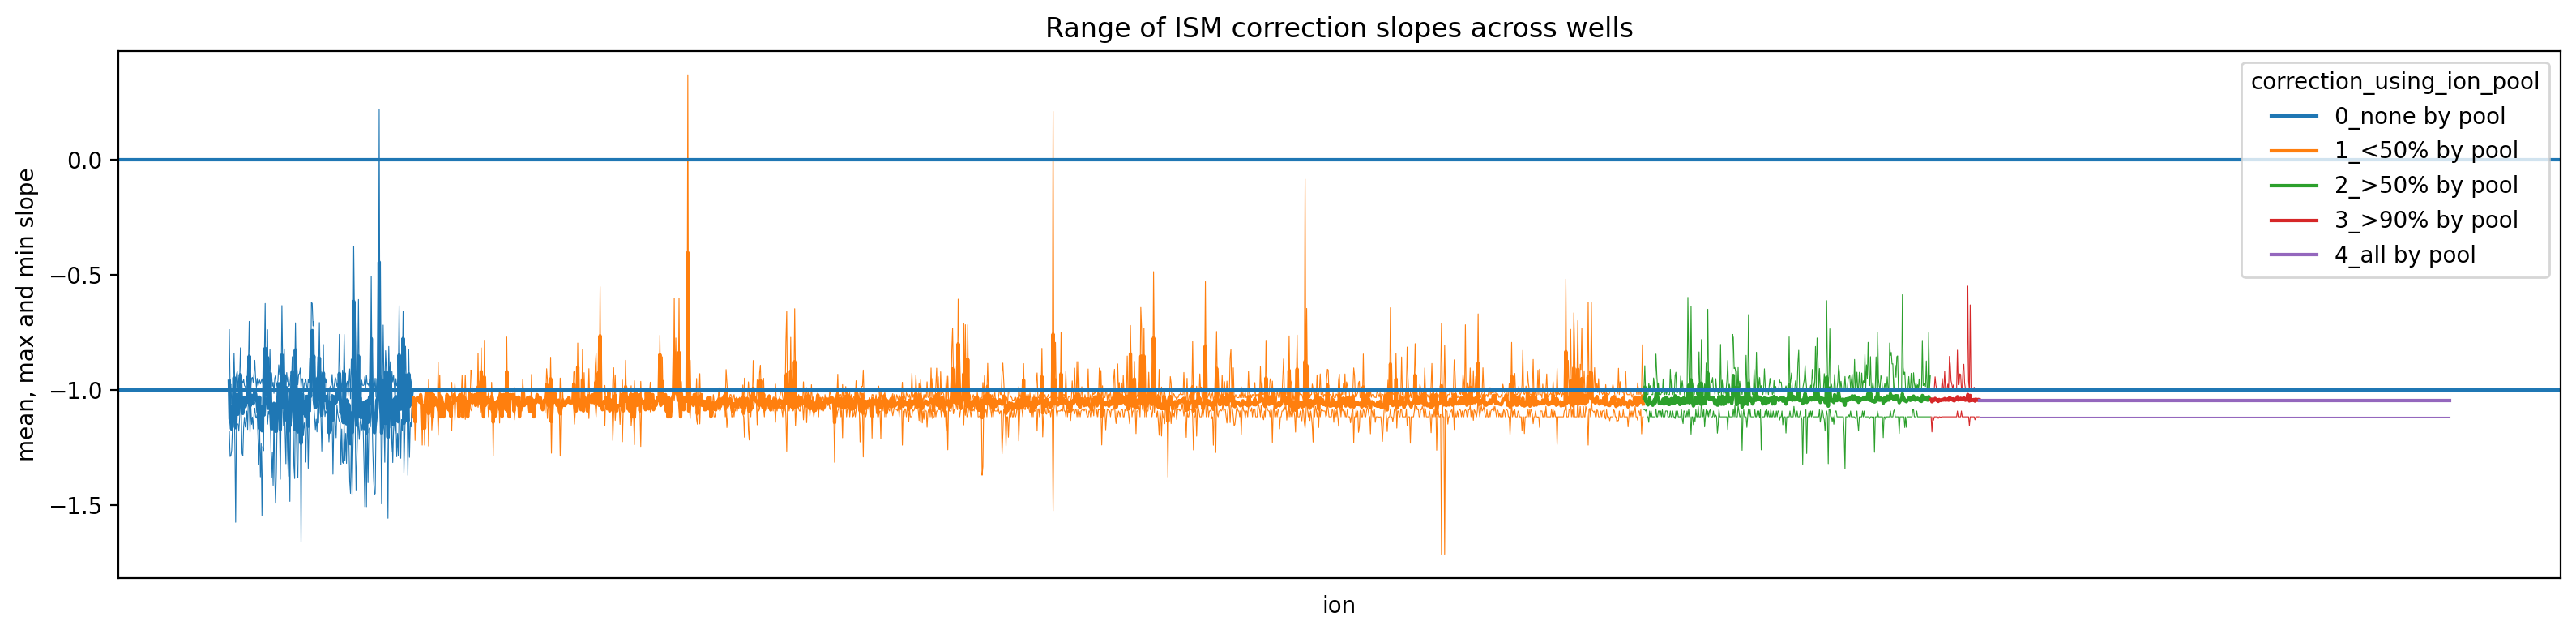

In [9]:
plot_range_slopes(adata_cor_dict)

The concatenated annotated data matrices are individually saved to file.

In [10]:
adata.write(os.path.join(target_path, "batch_sm_matrix.h5ad"))
gen_adata.write(os.path.join(target_path, "gen_batch_sm_matrix.h5ad"))
adata_cor.write(os.path.join(target_path, "corrected_batch_sm_matrix.h5ad"))

In order to ensure that especially the pixel-cell deconvolution was successful across samples, the summed absolute deviations between different annotated datasets are visualized in the following plot. On one hand, the uncorected but manually deconvoluted (generated) dataset is compared to the dataset directly output by SpaceM. If the same parameters were used for deconvolution, these dataset should not exhibit any differences. On the other hand, the corrected dataset is compared to the generated dataset. These dataset should exhibit differences on a comparable level across samples. If one of the samples shows much greater differences than the others, there might be a sample-specific problem with the parameters used for deconvolution.

In this case, the wells E2, E3 and E4 have a larger difference between the original SpaceM-derived and generated data than the other wells. This remains although I double-checked that all the correct parameters are used. Thus, some other step of the process seems to deviate from the original process, that I currently cannot pinpoint.

/tmp/ipykernel_3634/4077953098.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['well'] = df['cell_id'].str.replace('[0-9]+_', '')
/tmp/ipykernel_3634/4077953098.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['well'] = df['cell_id'].str.replace('[0-9]+_', '')


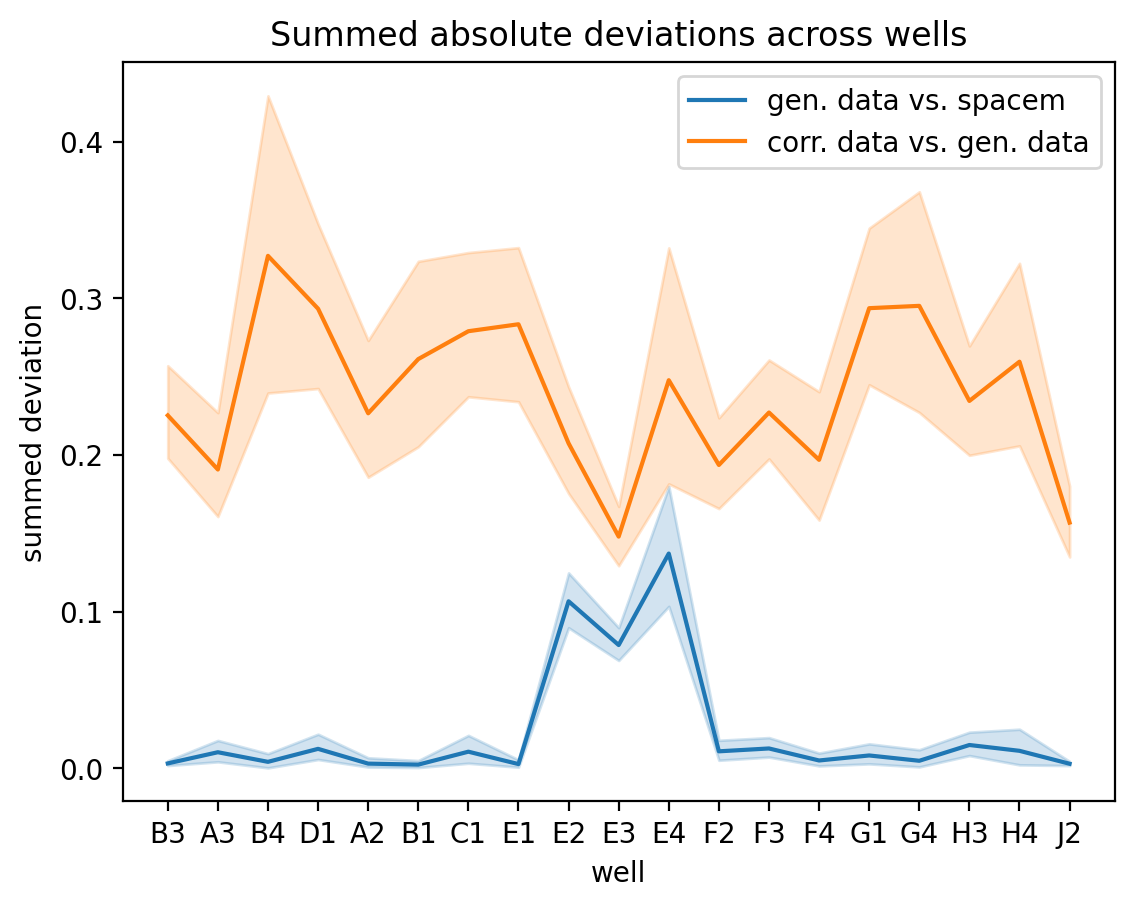

In [11]:
def plot_deviations(adata1, adata2, label=""):
    df = np.abs(adata1.to_df() - adata2.to_df()).sum(axis=1)
    df = df / (adata1.to_df().shape[0] * adata1.to_df().shape[1])
    df = df.reset_index()
    df['well'] = df['cell_id'].str.replace('[0-9]+_', '')
    df.columns = ['cell_id', 'summed deviation', 'well']
    sns.lineplot(df, x='well', y="summed deviation", label=label).set(title = 'Summed absolute deviations across wells')
    
plot_deviations(adata, gen_adata, 'gen. data vs. spacem')
plot_deviations(gen_adata, adata_cor, 'corr. data vs. gen. data')